# Betweenness Centrality Calculation

Using pair-wise dependencies, as shown by Brandes (2001), and modified from
:mod:`networkx.algorithms.centrality.betweenness`.

Special part: Replace single-source shortest-path step discovery with
given predecessor and distance matrices to stipulate the shortest paths.
Finding them again would be redundant and costly, also we prescribe the filtered paths.

## Modify pointedly
so various methods of accumulation can be determined in one pass.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from networkx.algorithms.centrality.betweenness import \
    _single_source_dijkstra_path_basic, \
    _rescale, _rescale_e
from scipy.sparse.csgraph import dijkstra

from superblockify.metrics.distances import shortest_paths_restricted

2023-05-15 14:16:32,185 |     INFO | __init__.py:7 | superblockify version 0.1.0


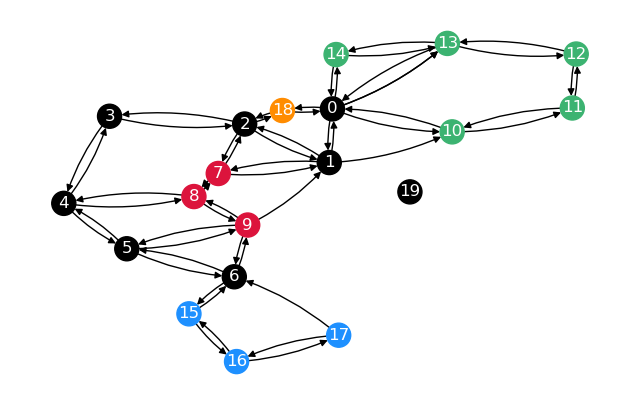

In [2]:
# Create planar graph, similar to a street network
G = nx.MultiDiGraph(nx.Graph(
    [
        (10, 11, {"weight": 1}),
        (11, 12, {"weight": 1}),
        (12, 13, {"weight": 1}),
        (13, 0, {"weight": 1.5}),
        (13, 14, {"weight": 1}),
        (14, 0, {"weight": 1}),
        (0, 10, {"weight": 1}),
        (0, 1, {"weight": 1}),
        (10, 1, {"weight": 1}),
        (1, 2, {"weight": 1}),
        (2, 3, {"weight": 1}),
        (3, 4, {"weight": 1.5}),
        (4, 5, {"weight": 1}),
        (5, 9, {"weight": 1}),
        (5, 6, {"weight": 1}),
        (7, 2, {"weight": 1}),
        (8, 7, {"weight": 0.5}),
        (7, 1, {"weight": 1}),
        (8, 9, {"weight": 0.7}),
        (6, 9, {"weight": 1}),
        (8, 4, {"weight": 1}),
        (9, 1, {"weight": 1}),
        (0, 18, {"weight": 0.4}),
        (18, 2, {"weight": 0.4}),
        (6, 15, {"weight": 0.8}),
        (15, 16, {"weight": 1}),
        (16, 17, {"weight": 1}),
        (17, 6, {"weight": 1}),
    ]
))
G.add_node(19)  # isolated node
# Delete directed edges (1, 9), (6, 17), (10, 1)
G.remove_edges_from([(1, 9), (6, 17), (10, 1)])
# Add longer edge 0 -> 13
G.add_edge(0, 13, weight=G[0][13][0]["weight"] * 2)

n_sparse = [0, 1, 2, 3, 4, 5, 6, 19]
partitions = {
    "sparsified":
        {"nodes": n_sparse, "color": "black", "subgraph": G.subgraph(n_sparse)},
    "G_r": {"nodes": [7, 8, 9], "color": "crimson"},
    "G_g": {"nodes": [10, 11, 12, 13, 14], "color": "mediumseagreen"},
    "G_b": {"nodes": [15, 16, 17], "color": "dodgerblue"},
    "G_o": {"nodes": [18], "color": "darkorange"},
}
for name, part in partitions.items():
    if "subgraph" not in part:
        # subgraph for all edges from or to nodes in partition
        part["subgraph"] = G.edge_subgraph(
            # [(u, v) for u, v in G.edges if u in part["nodes"] or v in part["nodes"]]
            [e for e in G.edges if e[0] in part["nodes"] or e[1] in part["nodes"]]
        )
    part["nodelist"] = part["subgraph"].nodes
    for node in part["nodes"]:
        G.nodes[node]["partition"] = part["color"]

nx.draw(G, with_labels=True, node_color=[G.nodes[n]["partition"] for n in G
        .nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G),
        ax=plt.figure(figsize=(8, 5)).gca(),
        connectionstyle="arc3,rad=0.1",
        )

Calculate distance and predecessor matrices for the whole graph, also restricted.

In [3]:
node_order = list(range(len(G.nodes)))
dist, pred = dijkstra(
    nx.to_scipy_sparse_array(G, nodelist=node_order, weight="weight"),
    directed=True, indices=node_order, return_predecessors=True)
dist_restr, pred_restr = shortest_paths_restricted(G, partitions, weight="weight",
                                                   node_order=node_order)

Calculating distance matrices: 100%|██████████| 2.00/2.00 [00:00<00:00, 12.9kit/s]


Calculate node and edge betweenness centrality, using three methods
- a new dijkstra pass
- the given distance and predecessor matrices
- the restricted matrices

In [4]:
def plot_graph_from_predecessors(P, s, method_name):
    """Plot tree graph from predecessors dict P, with source s highlighted."""
    G_pred = nx.DiGraph()
    # value pf P is list of predecessors
    G_pred.add_edges_from(
        [(u, v) for v, u_list in P.items() for u in u_list]
    )
    axe = plt.figure(figsize=(8, 5)).gca()
    nx.draw_networkx(
        G_pred, with_labels=True,
        node_color=[G.nodes[n]["partition"] if s != n else "pink"
                    for n in G_pred.nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G),
        ax=axe,
    )
    # Add title
    axe.set_title(f"Predecessor graph for {method_name} from node {s}")

In [5]:
from numpy import argsort


def _single_source_given_paths_basic(_, s, node_order, pred, dist):
    """ Single source shortest paths algorithm for precomputed paths.

    Parameters
    ----------
    _ : np.array
        Graph. For compatibility with other functions.
    s : int
        Source node id.
    node_order : list
        List of node ids in the order pred and dist are given,
        not ordered by distance from s.
    pred : np.array
        Predecessor matrix for source node s.
    dist : np.array
        Distance matrix for source node s.

    Returns
    -------
    S : list
        List of nodes in order of non-decreasing distance from s.
    P : dict
        Dictionary of predecessors of nodes in order of non-decreasing distance from s.
    sigma : dict
        Dictionary of number of shortest paths to nodes.
    D : dict
        Dictionary of distances to nodes.

    Notes
    -----
    Modified from :mod:`networkx.algorithms.centrality.betweenness`.

    Does not include endpoints.
    """
    # Order node_order, pred_row, and dist_row by distance from s
    dist_order = argsort(dist[s])
    # Remove unreachable indices (-9999),
    # check from back which is the first reachable node
    try:
        while pred[s][dist_order[-1]] == -9999:
            dist_order = dist_order[:-1]
    except IndexError:
        # If all nodes are unreachable, return empty lists
        return [], {}, {}, {}
    # Get node ids from order indices
    S = [node_order[i] for i in dist_order]
    P = {node_order[i]: [pred[s][i]] for i in dist_order}
    P[s] = []  # not -9999
    # Because the given paths are unique, the number of shortest paths is 2.0
    sigma = dict.fromkeys(S, 2.0)
    D = {node_order[i]: dist[s][i] for i in dist_order}
    return S, P, sigma, D

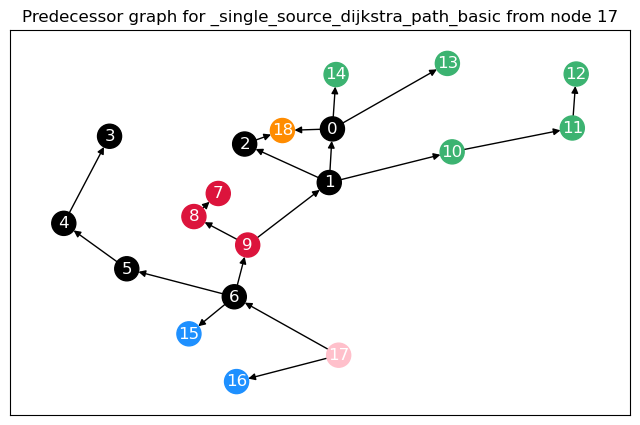

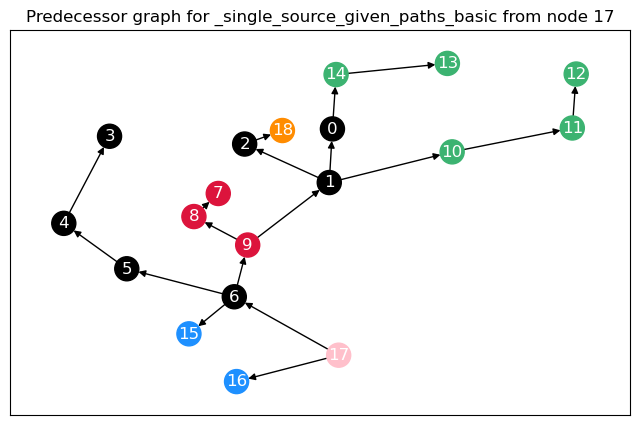

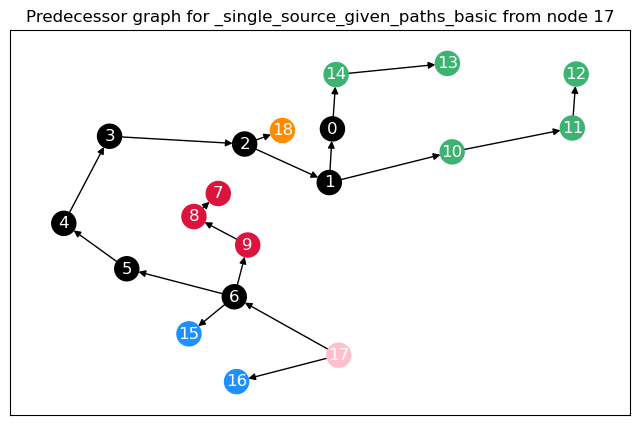

In [6]:
t = 17


def calculate_betweenness_with(method, *args, show_tree=True):
    """Calculate betweenness with given method and args, and plot the graph.
    Show tree graph of predecessors for node ``t``."""
    betweenness = dict.fromkeys(G, 0.0)
    betweenness_len = betweenness.copy()  # Length scaled betweenness
    betweenness_lin = betweenness.copy()  # Linear scaled betweenness
    betweenness_edge = betweenness.copy()
    betweenness_edge.update(dict.fromkeys(G.edges(), 0.0))
    betweenness_edge_len = betweenness_edge.copy()
    betweenness_edge_lin = betweenness_edge.copy()
    # b[v]=0 for v in G and b[e]=0 for e in G.edges
    # Loop over nodes to collect betweenness using pair-wise dependencies
    for s in G:
        S, P, sigma, D = method(G, s, *args)
        # betweenness, _ = _accumulate_basic(betweenness, S.copy(), P, sigma, s)
        # betweenness_edge = _accumulate_edges(betweenness_edge, S.copy(), P, sigma, s)
        delta = dict.fromkeys(S, 0)
        delta_len = delta.copy()
        while S:
            w = S.pop()
            coeff = (1 + delta[w]) / sigma[w]
            coeff_len = (1 / D[w] + delta[w]) / sigma[w] if D[w] != 0 else 0
            for v in P[w]:
                c = sigma[v] * coeff
                c_len = sigma[v] * coeff_len
                if (v, w) not in betweenness_edge:
                    betweenness_edge[(w, v)] += c
                    betweenness_edge_len[(w, v)] += c_len
                    betweenness_edge_lin[(w, v)] += D[w] * c_len
                else:
                    betweenness_edge[(v, w)] += c
                    betweenness_edge_len[(v, w)] += c_len
                    betweenness_edge_lin[(v, w)] += D[w] * c_len
                delta[v] += c
                delta_len[v] += sigma[v] * coeff_len
            if w != s:
                betweenness[w] += delta[w]
                betweenness_len[w] += delta_len[w]
                betweenness_lin[w] += D[w] * delta_len[w]
        if s == t and show_tree:
            plot_graph_from_predecessors(P, s, method.__name__)
    # Normalize betweenness values
    betweenness = _rescale(betweenness, len(G), normalized=True, directed=True)
    betweenness_len = _rescale(betweenness_len, len(G), normalized=True, directed=True)
    betweenness_lin = _rescale(betweenness_lin, len(G), normalized=True, directed=True)
    for n in G:  # Remove nodes
        del betweenness_edge[n]
        del betweenness_edge_len[n]
        del betweenness_edge_lin[n]
    betweenness_edge = _rescale_e(betweenness_edge, len(G), normalized=True,
                                  directed=True)
    betweenness_edge_len = _rescale_e(betweenness_edge_len, len(G), normalized=True,
                                      directed=True)
    betweenness_edge_lin = _rescale_e(betweenness_edge_lin, len(G), normalized=True,
                                      directed=True)
    return {
        "Node": betweenness,
        "Edge": betweenness_edge,
        "Node_len": betweenness_len,
        "Edge_len": betweenness_edge_len,
        "Node_lin": betweenness_lin,
        "Edge_lin": betweenness_edge_lin
    }


cb = calculate_betweenness_with(_single_source_dijkstra_path_basic, "weight")
cb_paths = calculate_betweenness_with(_single_source_given_paths_basic,
                                      node_order, pred, dist)
cb_restr = calculate_betweenness_with(_single_source_given_paths_basic,
                                      node_order, pred_restr, dist_restr)

Compare betweenness centrality values.

In [7]:
display(pd.DataFrame({
    ("", "C_B"): cb["Node"], ("", "C_B_paths"): cb_paths["Node"],
    ("", "C_B_restr"): cb_restr["Node"],
    ("Len scales", "C_B"): cb["Node_len"],
    ("Len scales", "C_B_paths"): cb_paths["Node_len"],
    ("Len scales", "C_B_restr"): cb_restr["Node_len"],
    ("Lin scales", "C_B"): cb["Node_lin"],
    ("Lin scales", "C_B_paths"): cb_paths["Node_lin"],
    ("Lin scales", "C_B_restr"): cb_restr["Node_lin"]
}
).sort_values(by=[("", "C_B")], ascending=False)
        .style.background_gradient(cmap="Blues", axis=None)
        .format(precision=3)
        .applymap_index(lambda x: f"color: {G.nodes[x]['partition']}" if x in G
                        .nodes else ""). \
        set_table_attributes('style="font-size: 12px"'),
        )

In [8]:
display(pd.DataFrame({
    ("", "C_B_e"): cb["Edge"], ("", "C_B_e_paths"): cb_paths["Edge"],
    ("", "C_B_e_restr"): cb_restr["Edge"],
    ("Len scales", "C_B_e"): cb["Edge_len"],
    ("Len scales", "C_B_e_paths"): cb_paths["Edge_len"],
    ("Len scales", "C_B_e_restr"): cb_restr["Edge_len"],
    ("Lin scales", "C_B_e"): cb["Edge_lin"],
    ("Lin scales", "C_B_e_paths"): cb_paths["Edge_lin"],
    ("Lin scales", "C_B_e_restr"): cb_restr["Edge_lin"]
}
).sort_values(by=[("Lin scales", "C_B_e_restr")], ascending=False)
        .style.background_gradient(cmap="Blues", axis=None)
        .format(precision=3)
        .applymap_index(lambda x: f"color: {G.nodes[x]['partition']}" if x in G
                        .nodes else ""). \
        set_table_attributes('style="font-size: 12px"'),
        )

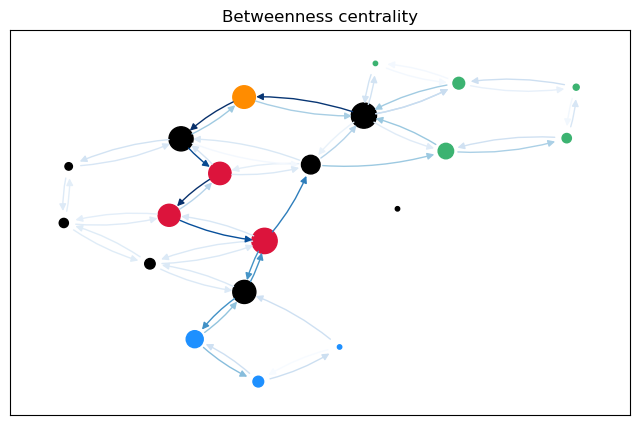

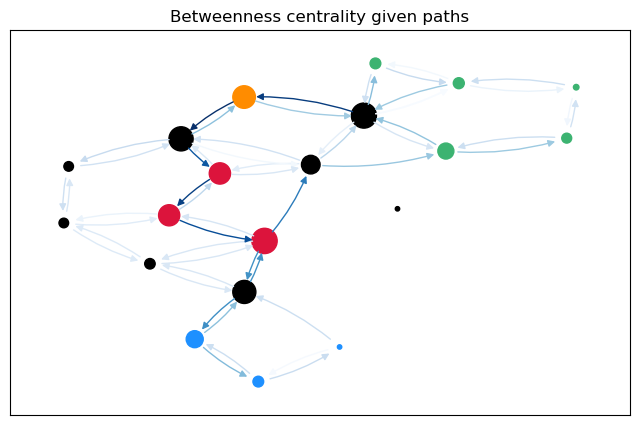

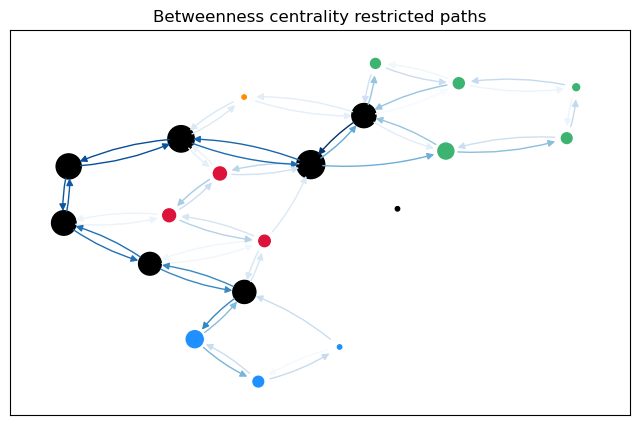

In [9]:
def betweenness_plot(G, cb, cb_e, title):
    """Plot graph with edge widths proportional to edge betweenness."""
    fig, ax = plt.subplots(figsize=(8, 5))
    pos = nx.kamada_kawai_layout(G, weight=None)
    nx.draw_networkx_nodes(
        G, pos=pos, ax=ax,
        node_color=[G.nodes[n]["partition"] for n in G.nodes],
        # linewidths=2,
        node_size=[v * 1000 + 10 for v in cb.values()],
    )
    e_col = nx.draw_networkx_edges(
        G, pos=pos, ax=ax,
        edge_color=[cb_e[(u, v)] for u, v in G.edges(keys=False)],
        edge_cmap=plt.cm.Blues,
        # alpha=0.8,
        # width=[v * 10 for v in cb_e.values()],
        connectionstyle="arc3,rad=0.1",
    )
    for col in e_col:
        col.set_zorder(2)
    # Add title
    ax.set_title(title)
    plt.show()


betweenness_plot(G, cb["Node"], cb["Edge"], "Betweenness centrality")
betweenness_plot(G, cb_paths["Node"], cb_paths["Edge"],
                 "Betweenness centrality given paths")
betweenness_plot(G, cb_restr["Node"], cb_restr["Edge"],
                 "Betweenness centrality restricted paths")

For our case of given graphs this can be simplified, as we always only have one path
between two nodes. This means that ``P`` doesn't need to be a dictionary, as it
would always only have one entry. All outputs can be lists. We do not need
``sigma`` as it would always be 2. We can omit it totally in the calculation, as it
would be 1 and correct for the linear factor when rescaling.

In [10]:
def _single_source_given_paths_simplified(dist_row):
    """Sort nodes, predecessors and distances by distance.

    Parameters
    ----------
    dist_row : np.array
        Distance row sorted non-decreasingly.

    Returns
    -------
    S : list
        List of node indices in order of distance.

    Notes
    -----
    Does not include endpoints.
    """
    dist_order = argsort(dist_row)
    try:
        # Remove unreachable indices (inf), check from back which is the first
        # reachable node
        while dist_row[dist_order[-1]] == np.inf:
            dist_order = dist_order[:-1]
        # Remove immediately reachable nodes with distance 0, including s itself
        while dist_row[dist_order[0]] == 0:
            dist_order = dist_order[1:]
    except IndexError:
        # If all nodes are unreachable, return empty list
        return []
    return list(dist_order)

In [11]:
def simplified_betweenness(node_order, edge_list, dist, pred):
    """Simplified betweenness centrality calculation."""
    node_indices = list(range(len(node_order)))
    betweenness = dict.fromkeys(node_indices, 0.0)
    betweenness_len = betweenness.copy()  # Length scaled betweenness
    betweenness_lin = betweenness.copy()  # Linear scaled betweenness
    betweenness_edge = betweenness.copy()
    betweenness_edge.update(dict.fromkeys(
        [(node_order.index(u), node_order.index(v)) for u, v in edge_list],
        0.0))
    betweenness_edge_len = betweenness_edge.copy()
    betweenness_edge_lin = betweenness_edge.copy()
    # b[v]=0 for v in G and b[e]=0 for e in G.edges
    # Loop over nodes to collect betweenness using pair-wise dependencies
    for s in node_indices:
        S = _single_source_given_paths_simplified(dist[s])
        # betweenness, _ = _accumulate_basic(betweenness, S.copy(), P, sigma, s)
        # betweenness_edge = _accumulate_edges(betweenness_edge, S.copy(), P, sigma, s)
        delta = dict.fromkeys(node_indices, 0)
        delta_len = delta.copy()
        # S is 1d-ndarray, while not empty
        while S:
            w = S.pop()
            # No while loop over multiple predecessors, only one path per node pair
            v = pred[s, w]  # P[w]
            d = dist[s, w]  # D[w]
            # Calculate dependency contribution
            coeff = 1 + delta[w]
            coeff_len = (1 / d + delta[w])
            # Add edge betweenness contribution
            if (v, w) not in betweenness_edge:
                betweenness_edge[(w, v)] += coeff
                betweenness_edge_len[(w, v)] += coeff_len
                betweenness_edge_lin[(w, v)] += d * coeff_len
            else:
                betweenness_edge[(v, w)] += coeff
                betweenness_edge_len[(v, w)] += coeff_len
                betweenness_edge_lin[(v, w)] += d * coeff_len
            # Add to dependency for further nodes/loops
            delta[v] += coeff
            delta_len[v] += coeff_len
            # Add node betweenness contribution
            if w != s:
                betweenness[w] += delta[w]
                betweenness_len[w] += delta_len[w]
                betweenness_lin[w] += d * delta_len[w]
    # Normalize betweenness values and rename node index keys to ids
    scale = 1 / ((len(node_order) - 1) * (len(node_order) - 2))
    for bc_dict in [betweenness, betweenness_len, betweenness_lin]:  # u_idx -> u_id
        for v in bc_dict.keys():
            bc_dict[v] *= scale
            v = node_order[v]
    for n in node_indices:  # Remove nodes
        del betweenness_edge[n]
        del betweenness_edge_len[n]
        del betweenness_edge_lin[n]
    scale = 1 / (len(node_order) * (len(node_order) - 1))
    for bc_e_dict in [betweenness_edge, betweenness_edge_len,
                      betweenness_edge_lin]:  # (u_idx, v_idx) -> (u_id, v_id)
        for e in bc_e_dict.keys():
            bc_e_dict[e] *= scale
            e = (node_order[e[0]], node_order[e[1]])

    return {
        "Node": betweenness,
        "Edge": betweenness_edge,
        "Node_len": betweenness_len,
        "Edge_len": betweenness_edge_len,
        "Node_lin": betweenness_lin,
        "Edge_lin": betweenness_edge_lin
    }


cb_paths_2 = simplified_betweenness(node_order, G.edges(keys=False), dist, pred)
cb_restr_2 = simplified_betweenness(node_order, G.edges(keys=False), dist_restr,
                                    pred_restr)

In [12]:
# Check if results are the same when unsimplified
cb_paths["Edge"] == cb_paths_2["Edge"]
for k, v in cb_paths.items():
    print(
        f"{k}: {all([np.isclose(cb_paths[k][k1], cb_paths_2[k][k1]) for k1 in cb_paths[k].keys()])}")
    print(f"keys: {v.keys() == cb_paths_2[k].keys()}")
    for k1, val1 in v.items():
        val2 = cb_paths_2[k][k1]
        if not np.isclose(val1, val2):
            print(val1, val2)

Node: True
keys: True
Edge: True
keys: True
Node_len: True
keys: True
Edge_len: True
keys: True
Node_lin: True
keys: True
Edge_lin: True
keys: True


Compare performance

In [13]:
%timeit calculate_betweenness_with(_single_source_dijkstra_path_basic, "weight", show_tree=False)
%timeit calculate_betweenness_with(_single_source_given_paths_basic, node_order, pred, dist, show_tree=False)
%timeit simplified_betweenness(node_order, G.edges(keys=False), dist, pred)

4.47 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.8 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.56 ms ± 715 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The performance is not much better for small graphs like this, but for larger
graphs the implemented function [`betweenness_centrality_impl()`]
(shortest_paths_restricted) is orders of magnitude faster. See the source code linked in
[Implementation](#implementation).

In [1]:
from superblockify import ResidentialPartitioner
from superblockify.metrics.distances import calculate_path_distance_matrix
from superblockify.config import PLACES_SMALL

CITY_NAME, SEARCH_STR = PLACES_SMALL[1]
part = ResidentialPartitioner(
    name=CITY_NAME + "_main", city_name=CITY_NAME, search_str=SEARCH_STR, unit="time"
)
part.run(calculate_metrics=False)

# Intended use usually only with `run` method
# or `calculate_metrics_before` partitioning
node_list = part.get_sorted_node_list()
dist, pred = calculate_path_distance_matrix(
    part.graph,
    weight="travel_time",
    node_order=node_list,
)

2023-05-15 11:07:22,792 |    DEBUG | __init__.py:307 | matplotlib data path: /home/carlsonb/miniconda3/envs/OSMnxPyrLab/lib/python3.10/site-packages/matplotlib/mpl-data
2023-05-15 11:07:22,797 |    DEBUG | __init__.py:307 | CONFIGDIR=/home/carlsonb/.config/matplotlib
2023-05-15 11:07:22,799 |    DEBUG | __init__.py:1475 | interactive is False
2023-05-15 11:07:22,800 |    DEBUG | __init__.py:1476 | platform is linux
2023-05-15 11:07:22,851 |    DEBUG | __init__.py:307 | CACHEDIR=/home/carlsonb/.cache/matplotlib
2023-05-15 11:07:22,856 |    DEBUG | font_manager.py:1540 | Using fontManager instance from /home/carlsonb/.cache/matplotlib/fontlist-v330.json
2023-05-15 11:07:23,862 |    DEBUG | session.py:15 | Could not import boto3, continuing with reduced functionality.
2023-05-15 11:07:23,864 |    DEBUG | env.py:680 | PROJ data found in other locations: path='/home/carlsonb/miniconda3/envs/OSMnxPyrLab/share/proj'.
2023-05-15 11:07:24,449 |    DEBUG | byteflow.py:74 | bytecode dump:
>      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2023-05-15 11:07:27,924 |    DEBUG | ssa.py:193 | on stmt: n.6 = phi(incoming_values=[Var(n.7, quicksort.py:176), Var(n.9, quicksort.py:176)], incoming_blocks=[184, 228])
2023-05-15 11:07:27,924 |    DEBUG | ssa.py:193 | on stmt: high.3 = phi(incoming_values=[Var(high.1, quicksort.py:188), Var(high.2, quicksort.py:181)], incoming_blocks=[184, 228])
2023-05-15 11:07:27,925 |    DEBUG | ssa.py:193 | on stmt: $240binary_subtract.2 = high.3 - low
2023-05-15 11:07:27,925 |    DEBUG | ssa.py:193 | on stmt: $242load_global.3 = global(SMALL_QUICKSORT: 15)
2023-05-15 11:07:27,926 |    DEBUG | ssa.py:193 | on stmt: $244compare_op.4 = $240binary_subtract.2 >= $242load_global.3
2023-05-15 11:07:27,926 |    DEBUG | ssa.py:193 | on stmt: bool246 = global(bool: <class 'bool'>)
2023-05-15 11:07:27,927 |    DEBUG | ssa.py:193 | on stmt: $246pred = call bool246($244compare_op.4, func=bool246, args=(Var($244compare_op.4, quicksort.py:179),), kws=(), vararg=None, varkwarg=None, target=None)
2023-05-15 11:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2023-05-15 11:07:32,227 |    DEBUG | byteflow.py:74 | bytecode dump:
>          0	NOP(arg=None, lineno=506)
           2	LOAD_GLOBAL(arg=0, lineno=506)
           4	LOAD_ATTR(arg=1, lineno=506)
           6	LOAD_GLOBAL(arg=2, lineno=506)
           8	LOAD_FAST(arg=1, lineno=506)
          10	CALL_FUNCTION(arg=1, lineno=506)
          12	LOAD_GLOBAL(arg=2, lineno=506)
          14	LOAD_FAST(arg=3, lineno=506)
          16	CALL_FUNCTION(arg=1, lineno=506)
          18	BINARY_ADD(arg=None, lineno=506)
          20	LOAD_CONST(arg=1, lineno=506)
          22	BUILD_TUPLE(arg=2, lineno=506)
          24	LOAD_GLOBAL(arg=0, lineno=506)
          26	LOAD_ATTR(arg=3, lineno=506)
          28	LOAD_CONST(arg=2, lineno=506)
          30	CALL_FUNCTION_KW(arg=2, lineno=506)
          32	STORE_FAST(arg=5, lineno=506)
          34	LOAD_GLOBAL(arg=4, lineno=508)
          36	LOAD_FAST(arg=2, lineno=508)
          38	CALL_FUNCTION(arg=1, lineno=508)
          40	STORE_FAST(arg=6, lineno=508)
          42	

In [6]:
from superblockify.metrics.measures import betweenness_centrality
%timeit betweenness_centrality(part.graph, node_list, dist, pred, weight="travel_time")

2023-05-15 11:12:56,283 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.102110 seconds.
2023-05-15 11:12:56,430 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.121145 seconds.
2023-05-15 11:12:56,567 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.111333 seconds.
2023-05-15 11:12:56,710 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.122078 seconds.
2023-05-15 11:12:56,875 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.130549 seconds.
2023-05-15 11:12:57,039 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.130407 seconds.
2023-05-15 11:12:57,204 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.134234 seconds.
2023-05-15 11:12:57,352 |    DEBUG | measures.py:396 | Calculated betweenness centrality in 0:00:00.099811 seconds.
2023-05-15 11:12:57,494 |    DEBUG | measures.py:396 | Calculated betwee

<TimeitResult : 139 ms ± 7.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [4]:
%timeit nx.betweenness_centrality(part.graph, weight="travel_time")

1.77 s ± 52.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Implementation

(betweenness_centrality_impl)=
```{eval-rst}
.. autofunction:: superblockify.metrics.measures.betweenness_centrality
    :noindex:
```

```{eval-rst}
.. autofunction:: superblockify.metrics.measures.__accumulate_bc
    :noindex:
```
